# Aero Mesh

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
import jaxopt, optax
from tinygp.kernels.stationary import ExpSquared

import pyvista as pv

pv.global_theme.trame.server_proxy_enabled = True
pv.start_xvfb(wait=2)

In [5]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
from emmd.utils import grid
from emmd.mmd import ImpCloudMMD, ScoreMMD, ergodic_metric
from emmd.transforms import Transform, ARD, DeepCK, MultiDeepCK
from emmd.kernels import RFF
from emmd.train import train_mmd_kernel, \
    train_mmd, train_mmd_kernel_gp, train_mmd_kernel_score
from emmd.gp import gp_pred
from emmd.mesh import o3d_mesh_to_pv, o3d_mesh_to_graph, knn_graph, trajectory_graph, \
    plot_3d_trajectory_pv, point_in_mesh_fn, plot_multi_3d_traj_pv, downsample_o3d_mesh, traj_to_line

In [7]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [9]:
key = jax.random.PRNGKey(0)

## Data

In [25]:
w = jnp.array([0.25, 0.75])
mu = jnp.array([[0.15, 0.15], [0.85, 0.85]])
sigma = jnp.array([[0.05, 0.1],[0.1, 0.05]])

gmm = tfd.Mixture(
    cat=tfd.Categorical(probs=w),
    components=[tfd.MultivariateNormalDiag(m, s) for m, s in zip(mu, sigma)]
)
samples = gmm.sample(1000, seed=key)
prob_s = gmm.prob(samples)

<Axes: >

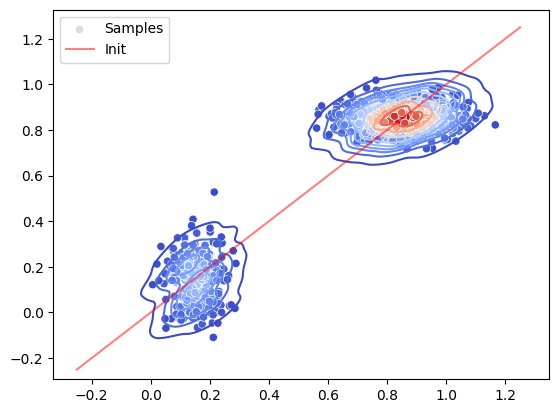

In [52]:
bounds = jnp.array([[-0.25, -0.25], [1.25, 1.25]])
# traj_init = jax.random.uniform(key, (100, 2), minval=bounds[0], maxval=bounds[1])
# traj_init = jax.random.choice(key, samples, replace=False, shape=(250,))
# traj_init = traj_init[traj_init[:, 0].argsort()]
traj_init = jnp.linspace(bounds[0], bounds[1], 150)

X = grid(bounds, N=100, flatten=True)
y = gmm.prob(X)
ls_init = jnp.sqrt(0.1)

sns.kdeplot(x=samples[:, 0], y=samples[:, 1], bw_adjust=0.6, cmap=cm.coolwarm)
sns.scatterplot(x=samples[:, 0], y=samples[:, 1], c=gmm.prob(samples), cmap=cm.coolwarm, label="Samples")
sns.lineplot(x=traj_init[:, 0], y=traj_init[:, 1], c='r', label="Init", sort=False, alpha=0.5)

In [28]:
# auxilary loss functions
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

## Model Definitions

In [18]:
def train_rbf_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), ExpSquared())
    k_rff_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    
    mmd_init = ImpCloudMMD(k_init, traj_init)
    mmd_rff_init = ImpCloudMMD(k_rff_init, traj_init)

    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, to_train=lambda t: [t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_rff_init, samples, prob_samples, to_train=lambda t: [t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [t.k.transform.scale, t.z, t.q_params, t.l]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [19]:
def train_rff_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))    
    mmd_init = ImpCloudMMD(k_init, traj_init)

    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l, R=R)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.kernel.w, t.k.transform.scale, t.z, t.q_params, t.l
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [20]:
def train_deep_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    n_hidden = kwargs.get("n_layers", 3)
    d_hidden = kwargs.get("d_hidden", 15)
    d_out = kwargs.get("out_dim", 8)
    n_kernels = kwargs.get("n_kernels", 3)
    k_init = MultiDeepCK(key, in_dim=d, out_dim=d_out, d_hidden=d_hidden, n_layers=n_hidden, n_kernels=n_kernels)
    mmd_init = ImpCloudMMD(k_init, traj_init)
    
    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l)

    # power training
    training_param_fn = lambda t: [
        t.k.mdk, t.k.ck.scale#, t.k.epsilon
    ]

    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=training_param_fn,
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=training_param_fn,
        lowrank=False, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.mdk, t.k.ck.scale, t.k.epsilon, t.z, t.q_params, t.l
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    # return mmd_init, mmd_power, mmd_score
    return mmd_init, mmd_power, mmd_gp, mmd_score


In [21]:
def train_trajectories(
        key, models, samples, bounds, aux_loss, 
        solver_params={}, use_adam=False, **kwargs
    ):

    if use_adam:
        def training_fn(model):
            return train_mmd(
                key, model, samples, aux_loss=aux_loss, optimizer="optax",
                **solver_params
            )

    else:
        def training_fn(model):
            return train_mmd(
                key, model, samples, bounds, aux_loss=aux_loss, 
                opt_params=solver_params
            )

    res = []
    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model_trained, _ = training_fn(model)
        res.append(model_trained)

    return res


## Run Models

In [22]:
epochs_k = 1500
epochs_mmd = 1000
lr = 1e-3

### RBF

In [34]:
rbf_power_params = {
    'epochs': 1000, 'lr': lr, 'verbose': True
}
rbf_gp_params = {
    "epochs": 2000, 'diag': 1e-3, 'lr': lr, 'verbose': True
}
rbf_score_params = {
    'lr': 1e-3, 'q': 'normal', #'q_params': bounds,
    'epochs': 2500, 'verbose': True
}

Train kernels:

In [35]:
rbf_init, rbf_power, rbf_gp, rbf_score = train_rbf_kernels(
    key, traj_init, samples, prob_s, bounds, rbf_power_params, rbf_gp_params, rbf_score_params
)

Training power
epoch 0,loss: 0.48146973752189043
epoch 50,loss: 0.48198020155634436
epoch 100,loss: 0.4823968916762873
epoch 150,loss: 0.4827327740787338
epoch 200,loss: 0.48300264152053973
epoch 250,loss: 0.48321936109901725
epoch 300,loss: 0.4833940842173895
epoch 350,loss: 0.48353634866658385
epoch 400,loss: 0.48365408640810925
epoch 450,loss: 0.4837536295628353
epoch 500,loss: 0.4838397873738352
epoch 550,loss: 0.48391602279078294
epoch 600,loss: 0.48398470825292433
epoch 650,loss: 0.48404740996871426
epoch 700,loss: 0.48410514874166993
epoch 750,loss: 0.48415860505027897
epoch 800,loss: 0.4842082604130855
epoch 850,loss: 0.48425448414992417
epoch 900,loss: 0.4842975813752195
epoch 950,loss: 0.4843378172650715
Training gp
epoch 0,loss: 156065.2734215766
epoch 50,loss: 131402.9596624478
epoch 100,loss: 122684.9228454992
epoch 150,loss: 118058.98409716024
epoch 200,loss: 113802.3685823681
epoch 250,loss: 106956.02296824839
epoch 300,loss: 91386.57097736704
epoch 350,loss: 64864.42695

In [36]:
rbf_models = (rbf_init, rbf_power, rbf_gp, rbf_score)

for model in rbf_models:
    print(f"Scale: {model.k.transform._scale}")

Scale: [0.18081917 0.10185481]
Scale: [0.35741061 0.12990351]
Scale: [0.09248988 0.05366406]
Scale: [0.24528314 0.08510543]


Train trajectories with MMD:

In [37]:
rbf_traj_init, rbf_power_traj, rbf_gp_traj, rbf_score_traj = train_trajectories(
        key, rbf_models, samples, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds,
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False, 
        # solver_params={'epochs': 1000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rbf_trajectories = (rbf_traj_init.w, rbf_power_traj.w, rbf_gp_traj.w, rbf_score_traj.w)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


### RFF

In [39]:
rff_power_params = {
    'epochs': 2000, 'lr': 1e-3, 'verbose': True
}
rff_gp_params = {
    "epochs": 2000, 'diag': 1e-4, 'lr': 1e-3, 'verbose': True
}
rff_score_params = {
    'lr': 1e-3, 'q': 'normal',
    'epochs': 2000, 'verbose': True
}

In [40]:
rff_init, rff_power, rff_gp, rff_score = train_rff_kernels(
    key, traj_init, samples, prob_s, bounds, rff_power_params, rff_gp_params, rff_score_params
)
rff_models = (rff_init, rff_power, rff_gp, rff_score)

Training power
epoch 0,loss: 0.4830258864146517
epoch 50,loss: 0.4869523613846467
epoch 100,loss: 0.48956190617010586
epoch 150,loss: 0.49113684615794995
epoch 200,loss: 0.49194171441218343
epoch 250,loss: 0.4922495590124041
epoch 300,loss: 0.49237442221287686
epoch 350,loss: 0.49245022514383274
epoch 400,loss: 0.4925126581468825
epoch 450,loss: 0.4925717543167845
epoch 500,loss: 0.49262984124463194
epoch 550,loss: 0.4926871336963037
epoch 600,loss: 0.4927434423504696
epoch 650,loss: 0.4927985333492677
epoch 700,loss: 0.49285219313679757
epoch 750,loss: 0.49290424037108516
epoch 800,loss: 0.49295452901763936
epoch 850,loss: 0.49300294965841773
epoch 900,loss: 0.49304942937342355
epoch 950,loss: 0.49309392983371225
epoch 1000,loss: 0.4931364436879587
epoch 1050,loss: 0.49317698976217994
epoch 1100,loss: 0.4932156077564521
epoch 1150,loss: 0.49325235304981685
epoch 1200,loss: 0.4932872920345917
epoch 1250,loss: 0.4933204981965383
epoch 1300,loss: 0.49335204899369434
epoch 1350,loss: 0.49

In [42]:
rff_traj_init, rff_power_traj, rff_gp_traj, rff_score_traj = train_trajectories(
        key, rff_models, samples, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False, 
        # solver_params={'epochs': 2500, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rff_trajectories = (rff_traj_init.w, rff_power_traj.w, rff_gp_traj.w, rff_score_traj.w)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


### Deep Kernel

In [46]:
deep_power_params = {
    'epochs': 1000, 'lr': 1e-3, 'verbose': True
}
deep_gp_params = {
    "epochs": 1, 'diag': 1e-4, 'lr': 1e-3, 'verbose': False
}
deep_score_params = {
    'lr': 1e-2, 'q': 'normal',
    'epochs': 3000, 'verbose': True
}

In [67]:
deep_init, deep_power, deep_gp, deep_score = train_deep_kernels(
    key, traj_init, samples, prob_s, bounds, deep_power_params, deep_gp_params, deep_score_params
)
deep_models = (deep_init, deep_power, deep_gp, deep_score)

Training power
epoch 0,loss: 0.48075230479947867
epoch 50,loss: 0.48262566737509793
epoch 100,loss: 0.49259355903971436
epoch 150,loss: 0.4958384511812792
epoch 200,loss: 0.4973189381625388
epoch 250,loss: 0.4982193656739431
epoch 300,loss: 0.4985740796316496
epoch 350,loss: 0.49878536250451727
epoch 400,loss: 0.4989756290398941
epoch 450,loss: 0.4991926581979973
epoch 500,loss: 0.49932746170065895
epoch 550,loss: 0.49941790837448075
epoch 600,loss: 0.4994824446687102
epoch 650,loss: 0.49953352720845495
epoch 700,loss: 0.4995740535215936
epoch 750,loss: 0.499605453254537
epoch 800,loss: 0.4996304348682754
epoch 850,loss: 0.4996497876118424
epoch 900,loss: 0.4996672797136472
epoch 950,loss: 0.49968319896404156
Training gp
Training score
epoch 0,loss: 18869.596633597394
epoch 50,loss: 238.87058818770086
epoch 100,loss: 21.733374840783913
epoch 150,loss: 8.74144036880036
epoch 200,loss: 5.192539079791518
epoch 250,loss: 0.6571956474668426
epoch 300,loss: -0.9723174552012228
epoch 350,loss

In [68]:
deep_traj_init, deep_power_traj, deep_score_traj = train_trajectories(
        key, (deep_init, deep_power, deep_score), samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-4, 'maxiter': 10_000}, use_adam=False, 
        # solver_params={'epochs': 3000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
deep_trajectories = (deep_traj_init.w, deep_power_traj.w, deep_score_traj.w)

Training model 1
{'tol': 0.0001, 'maxiter': 10000}
Training model 2
{'tol': 0.0001, 'maxiter': 10000}
Training model 3
{'tol': 0.0001, 'maxiter': 10000}


## Visualize

### RBF

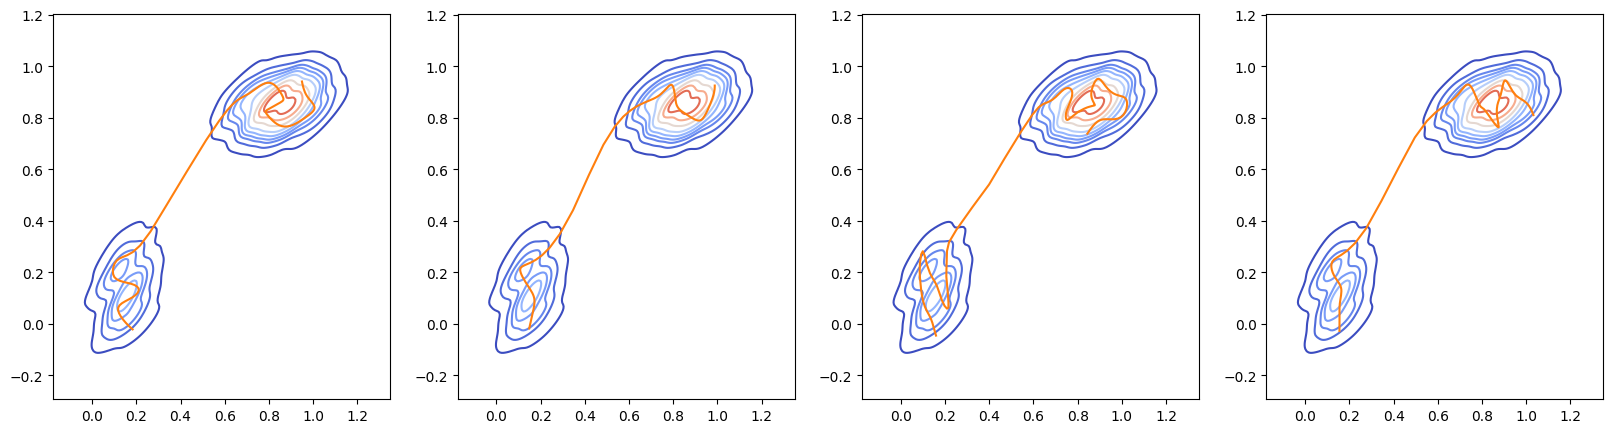

In [46]:
fig, ax = plt.subplots(1, len(rbf_trajectories), figsize=(5 * len(rbf_trajectories), 5))

for i, traj in enumerate(rbf_trajectories):
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], bw_adjust=0.6, cmap=cm.coolwarm, ax=ax[i])
    # sns.scatterplot(x=samples[:, 0], y=samples[:, 1], c=gmm.prob(samples), cmap=cm.coolwarm, label="Samples")
    sns.lineplot(x=traj[:, 0], y=traj[:, 1], ax=ax[i], sort=False)

In [58]:
for i, traj in enumerate(rbf_trajectories):
    metric = ergodic_metric(traj, bounds, n_modes=20, n_per_dim=100)
    print(jnp.mean((y - metric)**2))

3.9852287728378273
6.62220143624353
2.291389015240615
5.672199182578373


### RFF

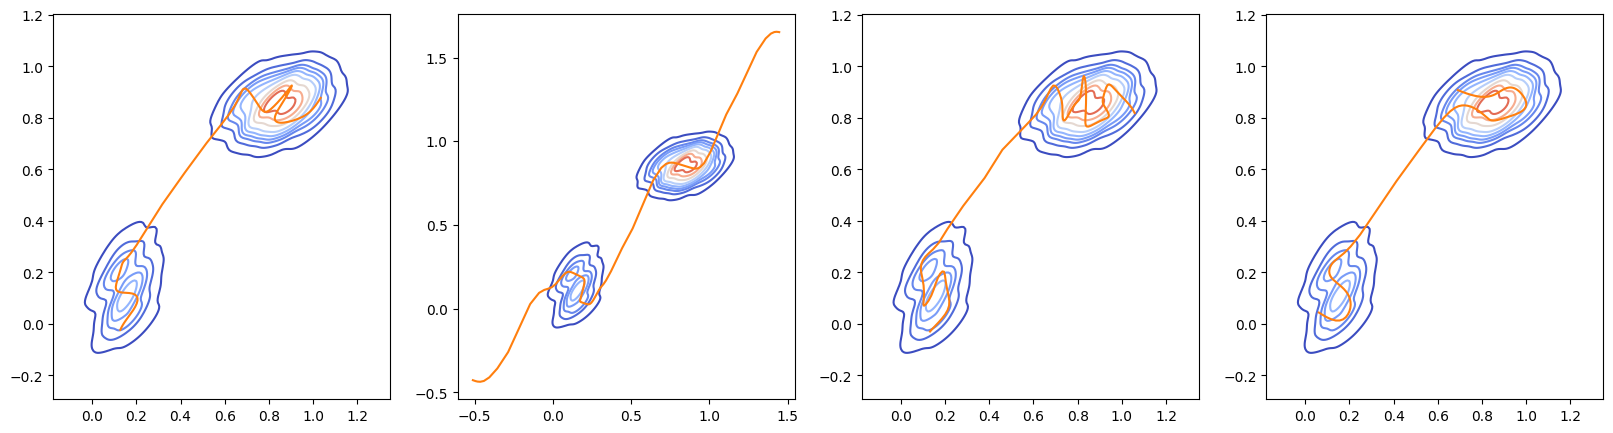

In [48]:
fig, ax = plt.subplots(1, len(rff_trajectories), figsize=(5 * len(rff_trajectories), 5))

for i, traj in enumerate(rff_trajectories):
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], bw_adjust=0.6, cmap=cm.coolwarm, ax=ax[i])
    # sns.scatterplot(x=samples[:, 0], y=samples[:, 1], c=gmm.prob(samples), cmap=cm.coolwarm, label="Samples")
    sns.lineplot(x=traj[:, 0], y=traj[:, 1], ax=ax[i], sort=False)

In [57]:
for i, traj in enumerate(rff_trajectories):
    metric = ergodic_metric(traj, bounds, n_modes=20, n_per_dim=100)
    print(jnp.mean((y - metric)**2))

4.893870390591234
12.526076657902877
2.103283608870886
3.645272800761025


In [51]:
y.shape

(1600,)

In [ ]:
rff_score_traj = eqx.tree_deserialise_leaves('rff_aero_score.eqx')

In [69]:
pl = pv.Plotter(notebook=True)
scaler = 1.0

rff_score_line = traj_to_line(rff_score_traj.w)
rff_score_line.points = rff_score_line.points * scaler
tube = line.tube(radius=0.002).smooth_taubin()

# scalars="von Mises stress",
pl.add_mesh(aero, opacity=0.45, cmap='Blues', show_scalar_bar=False)
pl.add_mesh(tube, smooth_shading=True, color="red", show_scalar_bar=False)
pl.add_points(pv.PointSet(lines[3].points), color='black', point_size=6, render_points_as_spheres=True)
pl.camera.tight(0.)
pl.camera.azimuth = 320
pl.camera.elevation = 16
# pl.camera.roll = 0
pl.camera.view_angle = 20
# pl.camera.clipping_range = (0.04036788261899782, 2.857547686199787)
# pl.save_graphic("aero_rbf_score.svg")
pl.show(jupyter_backend='pythreejs')

IndexError: list index out of range

### Deep Kernels

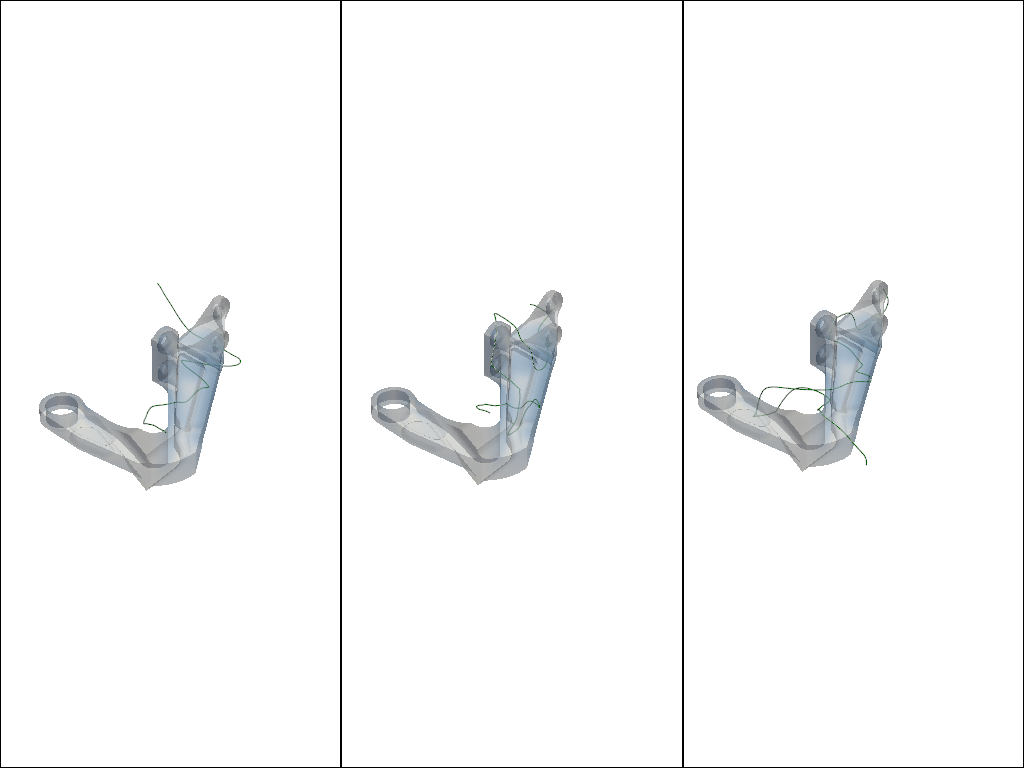

In [70]:
lines = [traj_to_line(traj) for traj in deep_trajectories]
shape = (1, 3)
pl = pv.Plotter(notebook=True, shape=shape)
opacity = 0.5

for j in range(shape[1]):
    pl.subplot(0, j)
    line = lines[j]
    tube = line.tube(radius=0.002)
    pl.add_mesh(aero, scalars="von Mises stress", opacity=opacity, cmap=mesh_cmap, show_scalar_bar=False)
    pl.add_mesh(tube, smooth_shading=True, color='green', show_scalar_bar=False)
pl.show(jupyter_backend='pythreejs')

In [79]:
eqx.tree_serialise_leaves('deep_aero_score.eqx', deep_score_traj)

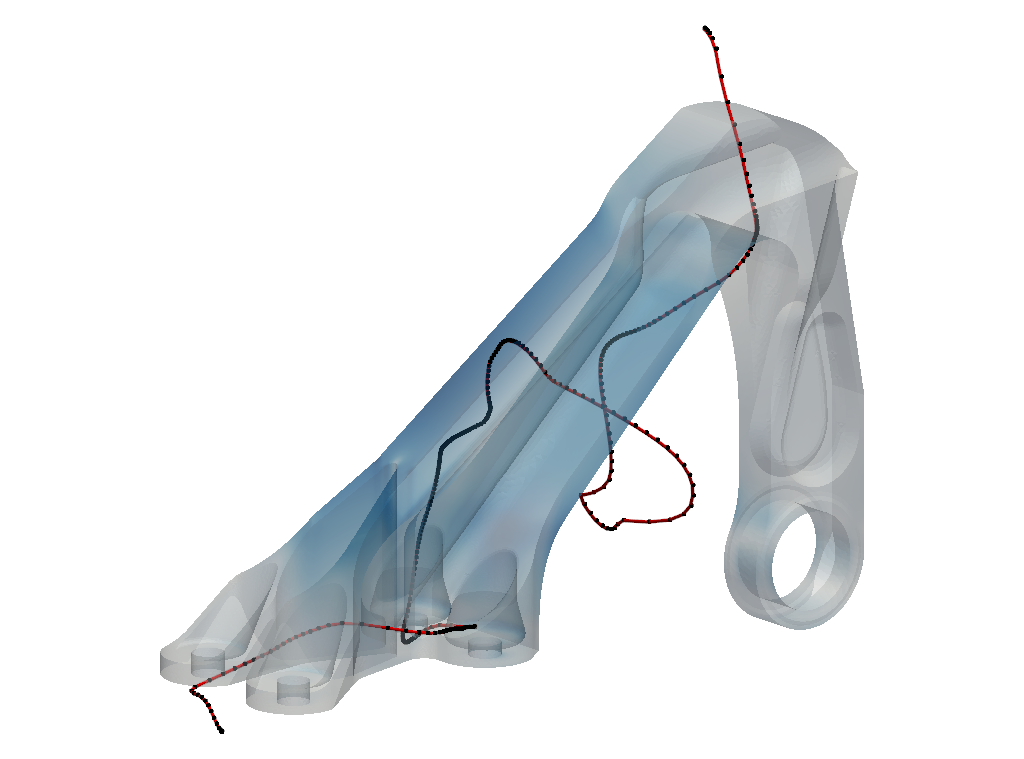

In [80]:
import numpy as np
pl = pv.Plotter(notebook=True)
scaler = 1.0

line = lines[2]
line.points = line.points * scaler
tube = line.tube(radius=0.002).smooth_taubin()

# scalars="von Mises stress",
pl.add_mesh(aero, opacity=0.45, cmap='Blues', show_scalar_bar=False)
pl.add_mesh(tube, smooth_shading=True, color="red", show_scalar_bar=False)
pl.add_points(pv.PointSet(lines[2].points), color='black', point_size=5, render_points_as_spheres=True)
pl.camera.tight(0.2)
pl.camera.azimuth = 320
pl.camera.elevation = 16
# pl.camera.roll = 0
pl.camera.view_angle = 0
# pl.camera.clipping_range = (0.04036788261899782, 2.857547686199787)
pl.save_graphic("aero_deep_score.svg")
pl.show(jupyter_backend='pythreejs')

## Metrics

In [14]:
def mse(x, y):
    return jnp.mean((x-y)**2)

### RBF

In [15]:
rbf_init_erg = ergodic_metric(rbf_traj_init.w, bounds, n_modes=20, n_per_dim=60)
rbf_power_erg = ergodic_metric(rbf_power_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_gp_erg = ergodic_metric(rbf_gp_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_score_erg = ergodic_metric(rbf_score_traj.w, bounds, n_modes=20, n_per_dim=60)

NameError: name 'rbf_traj_init' is not defined

In [123]:
# errors
mse(rbf_init_erg, prob_X_flat), mse(rbf_power_erg, prob_X_flat), \
    mse(rbf_gp_erg, prob_X_flat), mse(rbf_score_erg, prob_X_flat)

(Array(28.25934436, dtype=float64),
 Array(29.97701283, dtype=float64),
 Array(192.97166348, dtype=float64),
 Array(48.23838574, dtype=float64))

## Dev

In [14]:
from emmd.transforms import MultiDeepKernel, MultiDeepCK, DeepKernel
from emmd.score import ScoreKernel

In [15]:
mdk = MultiDeepKernel(key, in_dim=3, out_dim=5, d_hidden=15, n_layers=3)
c_mdk = MultiDeepCK(key, in_dim=3, out_dim=5, d_hidden=15, n_layers=3, n_kernels=3)
score = ScoreKernel(key, c_mdk, z=traj_init)
dk = DeepKernel(key, in_dim=3, out_dim=5, d_hidden=15, n_layers=3)

from emmd

In [18]:
score = ScoreKernel(key, c_mdk, z=traj_init, l=jnp.ones(2) * 1e-5)
alpha = score.compute_alpha(samples)